In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
import pickle
from elephant.signal_processing import wavelet_transform
from elephant.spectral import welch_psd
from matplotlib.patches import Rectangle
import time
import seaborn as sns
sns.set_theme()

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.visualization import plot_running_speed

In [2]:
output_dir = Path.home() / 'Desktop' / 'disk2' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')
channel_df = cache.get_channels()
probes_df = cache.get_probes()

# 1) Load session with probes in VISp and VISpm

In [3]:
with open('VISpm_VISp_probes.pkl', 'rb') as f:
    probe_list = pickle.load(f)

probe_dict = {e[0]: [e[1], e[2]] for e in probe_list}    
print('{session_id: [VISpm/VISp_probe_1, VISpm/VISp_probe_2]}')
probe_dict

{session_id: [VISpm/VISp_probe_1, VISpm/VISp_probe_2]}


{719161530: [729445650, 729445652],
 732592105: [733744647, 733744649],
 754312389: [756781555, 756781557],
 750332458: [757904547, 757904550],
 751348571: [757984818, 757984820],
 737581020: [757988389, 757988391],
 756029989: [760640087, 760640090],
 755434585: [760642624, 760642628],
 761418226: [768908582, 768908585],
 742951821: [769322714, 769322716],
 759883607: [769322789, 769322793],
 750749662: [769322804, 769322806],
 760693773: [769322824, 769322827],
 758798717: [770930071, 770930073],
 767871931: [773462990, 773462993],
 771160300: [773621939, 773621942],
 771990200: [773654726, 773654728],
 778240327: [792607547, 792607549],
 786091066: [792623919, 792623921],
 778998620: [792626844, 792626847],
 779839471: [792645493, 792645497],
 791319847: [805008602, 805008604],
 797828357: [805579738, 805579741],
 760345702: [810753197, 810753199],
 715093703: [810755799, 810755801],
 794812542: [810758779, 810758781],
 821695405: [822645895, 822645897],
 831882777: [832810576, 8328

In [4]:
# Loading the selected session and determining which probe is VISpm/VISp
session_id = 715093703
selected_session_list = probe_dict[session_id]

session = cache.get_session_data(session_id)

if 'VISpm' in probes_df[probes_df.index==selected_session_list[0]].ecephys_structure_acronyms.item():
    selected_VISpm_probe_id = selected_session_list[0]
    selected_VISp_probe_id = selected_session_list[1]
else:
    selected_VISpm_probe_id = selected_session_list[1]
    selected_VISp_probe_id = selected_session_list[0]

In [5]:
t1 = time.time()
VISpm_lfp = session.get_lfp(selected_VISpm_probe_id)
print(f'LFP data loaded in {time.time()-t1} seconds.')
t1 = time.time()
VISp_lfp = session.get_lfp(selected_VISp_probe_id)
print(f'LFP data loaded in {time.time()-t1} seconds.')
VISp_lfp

LFP data loaded in 22.114222526550293 seconds.
LFP data loaded in 20.061102151870728 seconds.


<xarray.DataArray 'LFP' (time: 11070604, channel: 95)>
array([[-3.7049998e-05, -4.1535000e-05, -5.5184999e-05, ...,
         2.1450001e-06, -3.1200000e-06, -1.5600000e-06],
       [ 1.6185000e-05, -2.1840000e-05, -4.1924999e-05, ...,
        -1.3650000e-06,  1.3650000e-06, -3.9000001e-06],
       [ 3.0224999e-05,  8.1899998e-06, -2.0084999e-05, ...,
         7.2150001e-06, -9.9449999e-06, -5.6549998e-06],
       ...,
       [ 3.0498000e-04,  3.2350500e-04,  2.9328000e-04, ...,
         5.8500000e-06,  2.4569999e-05, -4.0560000e-05],
       [ 2.1235499e-04,  2.6305500e-04,  2.5740001e-04, ...,
         5.0700000e-06,  2.6129999e-05, -4.1730000e-05],
       [ 1.6165500e-04,  1.8973500e-04,  1.7218500e-04, ...,
         7.7999999e-07,  8.5800002e-06, -1.6380000e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 26.88 26.89 26.89 ... 9.578e+03 9.578e+03 9.578e+03
  * channel  (channel) int64 850261198 850261206 ... 850261942 850261950

# 2) Get the 100-300-100s times of the relevant (flash) stimulus block

In [6]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,13.470683,73.537433,60.066750,spontaneous,null
1,73.537433,985.532551,911.995118,gabors,0.0
2,985.532551,1274.523973,288.991422,spontaneous,null
3,1274.523973,1573.023407,298.499434,flashes,1.0
4,1573.023407,1574.774823,1.751416,spontaneous,null
5,1574.774823,2174.275707,599.500885,drifting_gratings,2.0
6,2174.275707,2205.301633,31.025925,spontaneous,null
7,2205.301633,2805.836653,600.535020,natural_movie_three,3.0
8,2805.836653,2835.861733,30.025080,spontaneous,null
9,2835.861733,3136.112583,300.250850,natural_movie_one,4.0


In [7]:
flash_index = stim_epochs[stim_epochs.stimulus_name=='flashes'].index.item()

print('No stimulus block before flashes:')
print(stim_epochs[stim_epochs.index==flash_index-1])
print('\nFlashes block:')
print(stim_epochs[stim_epochs.index==flash_index])
print('\nNo stimulus block after flashes:')
print(stim_epochs[stim_epochs.index==flash_index+1])

No stimulus block before flashes:
   start_time    stop_time    duration stimulus_name stimulus_block
2  985.532551  1274.523973  288.991422   spontaneous           null

Flashes block:
    start_time    stop_time    duration stimulus_name stimulus_block
3  1274.523973  1573.023407  298.499434       flashes            1.0

No stimulus block after flashes:
    start_time    stop_time  duration stimulus_name stimulus_block
4  1573.023407  1574.774823  1.751416   spontaneous           null


In [8]:
global_start_time = stim_epochs[stim_epochs.index==flash_index-1].start_time.item()
global_end_time = stim_epochs[stim_epochs.index==flash_index+1].stop_time.item()

spontaneous_before_start_time = global_start_time
spontaneous_before_end_time = stim_epochs[stim_epochs.index==flash_index-1].stop_time.item()

flashes_start_time = stim_epochs[stim_epochs.index==flash_index].start_time.item()
flashes_end_time = stim_epochs[stim_epochs.index==flash_index].stop_time.item()

spontaneous_after_start_time = stim_epochs[stim_epochs.index==flash_index+1].start_time.item()
spontaneous_after_end_time = global_end_time

print(f'Looking at {global_start_time}s - {global_end_time}s time range')

Looking at 985.5325513570875s - 1574.7748229367066s time range


# 3) Select channels from VISp and VISpm only, select time range defined above only

In [9]:
# Quality check for channels that are in the LFP NWB file but not in the Allen cache
for ch in VISpm_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISpm_lfp = VISpm_lfp.drop_sel(channel=ch)
for ch in VISp_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISp_lfp = VISp_lfp.drop_sel(channel=ch)

In [10]:
def get_every_area_channel_id_dict(merged_df):
    probe_every_area_channel_ids = {}
    for area in merged_df.ecephys_structure_acronym.unique():
        if pd.isnull(area): # to select NaN area key
            probe_every_area_channel_ids['NaN'] = merged_df[pd.isna(merged_df.ecephys_structure_acronym)].index.to_list()  # works for selecting channels from the NaN area
        else:
            probe_every_area_channel_ids[area] = merged_df[merged_df.ecephys_structure_acronym==area].index.to_list()
    return probe_every_area_channel_ids

In [11]:
# Organise all channels into a dictionary with keys as area names and values as lists with related LFP recording channels
VISpm_cache_channel_df_merged = channel_df.loc[VISpm_lfp.channel.values]
VISp_cache_channel_df_merged = channel_df.loc[VISp_lfp.channel.values]

VISpm_probe_every_area_channel_ids = get_every_area_channel_id_dict(VISpm_cache_channel_df_merged)
VISp_probe_every_area_channel_ids = get_every_area_channel_id_dict(VISp_cache_channel_df_merged)

# VISpm_channel_ids = [ch for ch in VISpm_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISpm']
# VISp_channel_ids = [ch for ch in VISp_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISp']

VISpm_channel_ids = VISpm_probe_every_area_channel_ids['VISpm']
VISp_channel_ids = VISp_probe_every_area_channel_ids['VISp']

print(f'VISpm channels = {len(VISpm_channel_ids)}')
print(f'VISp channels = {len(VISp_channel_ids)}')

VISpm channels = 16
VISp channels = 23


In [12]:
VISpm_lfp_slice = VISpm_lfp.sel(time=slice(global_start_time, global_end_time))
VISp_lfp_slice = VISp_lfp.sel(time=slice(global_start_time, global_end_time))

# 4) Plot the LFP signal from all channels from VISp and VISpm side by side. Choose channel with maximum signal

In [13]:
def get_max_channel_id(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return int(np.argmax(max_amplitudes.data))

def get_max_channel_id_list(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return np.argsort(-max_amplitudes).data

In [14]:
# For each area in the two probes, determine max amplitude channel/s
VISpm_probe_every_area_max_channel = {}
VISpm_probe_every_area_max_channel_list = {}
VISp_probe_every_area_max_channel = {}
VISp_probe_every_area_max_channel_list = {}

for area, ch_ids in VISpm_probe_every_area_channel_ids.items():
    VISpm_probe_every_area_max_channel[area] = ch_ids[get_max_channel_id(VISpm_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))]
    VISpm_probe_every_area_max_channel_list[area] = get_max_channel_id_list(VISpm_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))
for area, ch_ids in VISp_probe_every_area_channel_ids.items():
    VISp_probe_every_area_max_channel[area] = ch_ids[get_max_channel_id(VISp_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))]
    VISp_probe_every_area_max_channel_list[area] = get_max_channel_id_list(VISp_lfp_slice.sel(channel=slice(ch_ids[0], ch_ids[-1])))

VISpm_max_channel = VISpm_probe_every_area_max_channel['VISpm']
VISpm_max_channel_list = VISpm_probe_every_area_max_channel_list['VISpm']
VISp_max_channel = VISp_probe_every_area_max_channel['VISp']
VISp_max_channel_list = VISp_probe_every_area_max_channel_list['VISp']

print(f'VISpm_max_channel = {VISpm_max_channel}')
print(f'VISp_max_channel = {VISp_max_channel}')

VISpm_max_channel = 850263332
VISp_max_channel = 850261814


In [15]:
VISp_channel_ids[VISp_max_channel_list[0]]

850261814

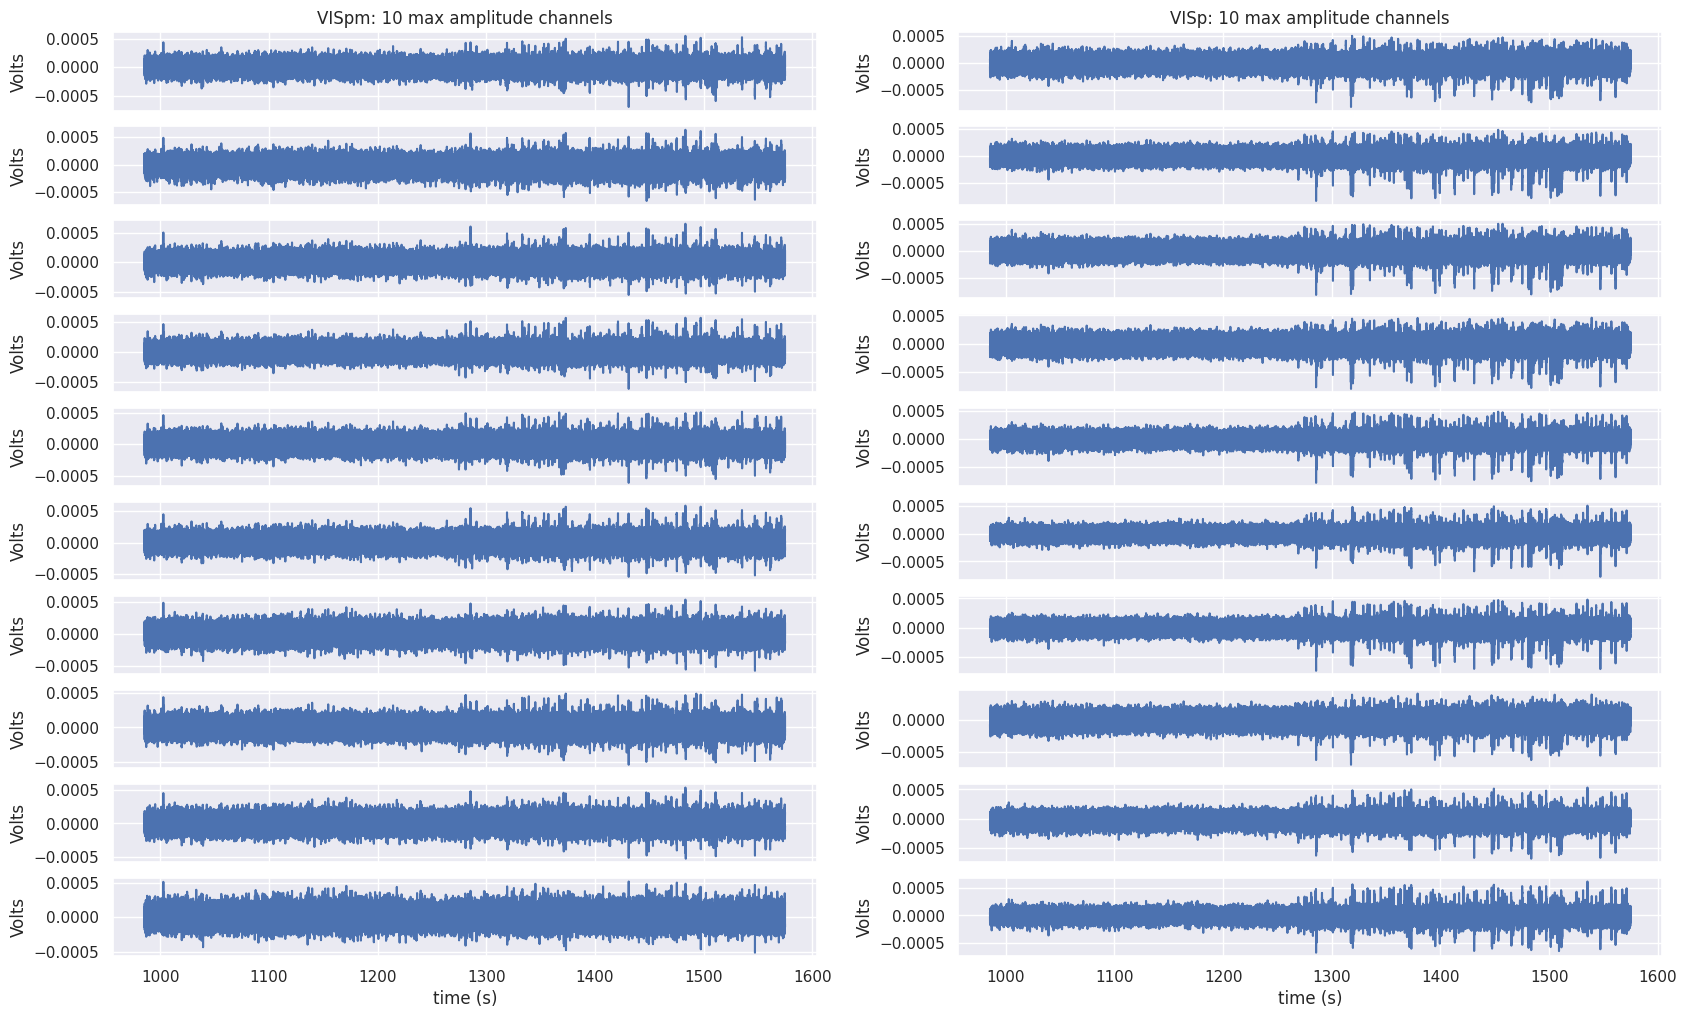

In [17]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 12), sharex=True)
for i in range(10):
    axes[i][0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[VISpm_max_channel_list[i]]))
    axes[i][0].set_ylabel(f'Volts')
axes[i][0].set_xlabel('time (s)')
axes[0][0].set_title('VISpm: 10 max amplitude channels')

for i in range(10):
    axes[i][1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[VISp_max_channel_list[i]]))
    axes[i][1].set_ylabel(f'Volts')
axes[i][1].set_xlabel('time (s)')
axes[0][1].set_title('VISp: 10 max amplitude channels')


plt.show()

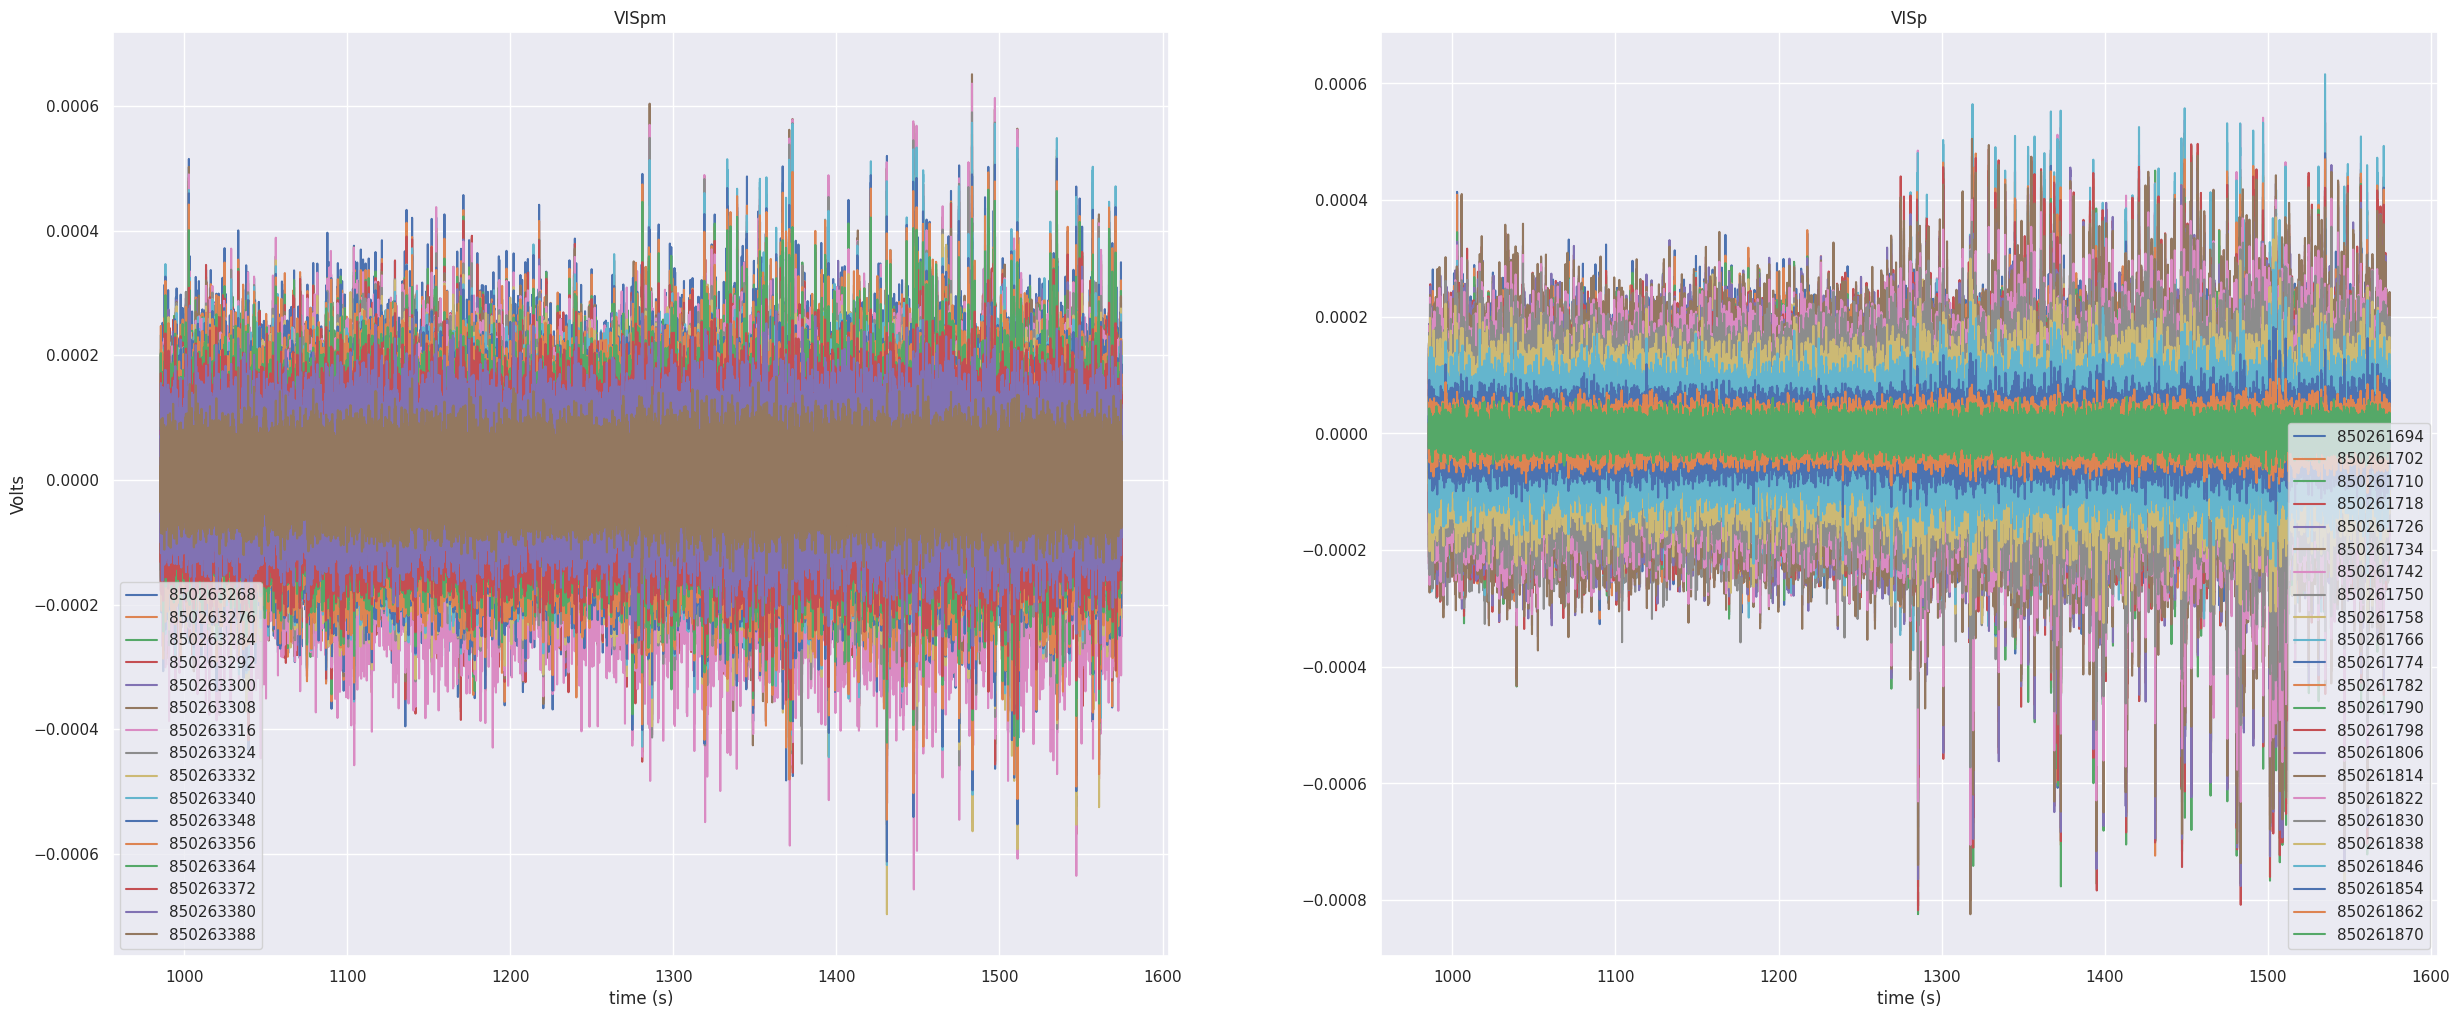

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), sharex=True)
for i in range(len(VISpm_channel_ids)):
    axes[0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[i]))
axes[0].set_ylabel(f'Volts')
axes[0].set_xlabel('time (s)')
axes[0].legend(VISpm_channel_ids)
axes[0].set_title('VISpm')

for i in range(len(VISp_channel_ids)):
    axes[1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[i]))
axes[1].set_xlabel('time (s)')
axes[1].legend(VISp_channel_ids)
axes[1].set_title('VISp')

plt.show()

# 5) Compute spectrogram from that channel

In [19]:
# Wavelet Transform Parameters
fs = 1250
MAX_FREQUENCY = 100
SPACING_BETWEEN_FREQUENCIES = 0.1
LOAD_WT_DATA = False
DATA_SAVE_PATH = Path.home() / 'Desktop' / 'disk2'

In [20]:
def get_freq_list(MAX_FREQUENCY,SPACING_BETWEEN_FREQUENCIES):
    freq_list = np.arange(0,MAX_FREQUENCY+SPACING_BETWEEN_FREQUENCIES,SPACING_BETWEEN_FREQUENCIES)
    print('Frequency list shape:',freq_list.shape)
    print('First five frequencies:',freq_list[:5])
    print('Last five frequencies:',freq_list[-5:])
    return freq_list

In [21]:
VISpm_filename = f'VISpm_wtData_session_{session_id}_probeID_{selected_VISpm_probe_id}_samplingFreq_{fs}_maxFreq_{MAX_FREQUENCY}_frequencySpacing_{SPACING_BETWEEN_FREQUENCIES}.pkl'
VISp_filename = f'VISp_wtData_session_{session_id}_probeID_{selected_VISp_probe_id}_samplingFreq_{fs}_maxFreq_{MAX_FREQUENCY}_frequencySpacing_{SPACING_BETWEEN_FREQUENCIES}.pkl'

freq_list = get_freq_list(MAX_FREQUENCY,SPACING_BETWEEN_FREQUENCIES)

if LOAD_WT_DATA:
    with open(DATA_SAVE_PATH/VISpm_filename, 'rb') as f:
        VISpm_wt_data = pickle.load(f)
    with open(DATA_SAVE_PATH/VISp_filename, 'rb') as f:
        VISp_wt_data = pickle.load(f)
else:    
    t1 = time.time()
    VISpm_wt_data = wavelet_transform(VISpm_lfp_slice.sel(channel=VISpm_max_channel), frequency=freq_list, sampling_frequency=fs)
    print(f'Morlet transform computed in {time.time() - t1} seconds')
    
    with open(DATA_SAVE_PATH/VISpm_filename, 'wb') as f:
        pickle.dump(VISpm_wt_data, f, protocol=4)
    print('Saved into pickle file')
    
    t1 = time.time()
    VISp_wt_data = wavelet_transform(VISp_lfp_slice.sel(channel=VISp_max_channel), frequency=freq_list, sampling_frequency=fs)
    print(f'Morlet transform computed in {time.time() - t1} seconds')
    
    with open(DATA_SAVE_PATH/VISp_filename, 'wb') as f:
        pickle.dump(VISp_wt_data, f, protocol=4)
    print('Saved into pickle file')

Frequency list shape: (1001,)
First five frequencies: [0.  0.1 0.2 0.3 0.4]
Last five frequencies: [ 99.6  99.7  99.8  99.9 100. ]


FileNotFoundError: [Errno 2] No such file or directory: '/home/ikharitonov/Desktop/VISpm_wt_data_2.npy'

In [ ]:
# Plotting Parameters
X_TICKS_NUMBER = 10
Y_TICKS_NUMBER = 10
X_LIM = [1330,1400]
Y_LIM = [0,50]

In [ ]:
def get_index_of_highest_below_value(arr, value):
    mask = arr < value  # Create a boolean mask of values below the specific value
    indices = np.where(mask)  # Get the indices where the mask is True
    if indices[0].size > 0: return indices[0][np.argmax(arr[mask])]  # Return the index with the highest value
    else: return 0  # Return None if no values are below the specific value

def get_index_of_lowest_above_value(arr, value):
    mask = arr > value  # Create a boolean mask of values below the specific value
    indices = np.where(mask)  # Get the indices where the mask is True
    if indices[0].size > 0: return indices[0][np.argmin(arr[mask])]  # Return the index with the highest value
    else: return arr.shape[0]-1  # Return None if no values are below the specific value

def plot_wt(fig,ax,wt_data,lfp_slice,title,v_vals):
    # Refresh frequency list (to avoid breaking if plotting in rerun)
    freq_list = get_freq_list(MAX_FREQUENCY,SPACING_BETWEEN_FREQUENCIES)

    # Apply x-axis limits to the ticks
    x_ticks_list = lfp_slice.time.data
    t1 = get_index_of_highest_below_value(x_ticks_list,X_LIM[0])
    t2 = get_index_of_lowest_above_value(x_ticks_list,X_LIM[1])
    x_ticks_list = x_ticks_list[t1:t2]

    # Apply y-axis limits to frequency list
    f1 = get_index_of_highest_below_value(freq_list,Y_LIM[0])
    f2 = get_index_of_lowest_above_value(freq_list,Y_LIM[1])
    freq_list = freq_list[f1:f2]

    print(f'number of y ticks ({np.arange(0, len(freq_list)+freq_list.shape[0]/Y_TICKS_NUMBER, freq_list.shape[0]/Y_TICKS_NUMBER).shape[0]}) == number of y tick labels ({np.arange(Y_LIM[0],Y_LIM[1]+(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER,(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER).shape[0]})')

    # Plot the data with appropriate limits
    im = ax.imshow(np.abs(wt_data)[f1:f2,t1:t2],aspect='auto',origin='lower',vmin=v_vals[0], vmax=v_vals[1])

    # Set the values of ticks
    ax.set_xticks(np.linspace(0,wt_data[f1:f2,t1:t2].shape[1],num=X_TICKS_NUMBER))
    ax.set_xticklabels(np.linspace(x_ticks_list[0],x_ticks_list[-1], num=X_TICKS_NUMBER).astype(int))
    ax.set_yticks(np.arange(0, len(freq_list)+freq_list.shape[0]/Y_TICKS_NUMBER, freq_list.shape[0]/Y_TICKS_NUMBER))
    ax.set_yticklabels(np.arange(Y_LIM[0],Y_LIM[1]+(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER,(Y_LIM[1]-Y_LIM[0])/Y_TICKS_NUMBER))

    ax.set_xlabel("time (s)", fontsize=15)
    ax.set_ylabel("frequency (Hz)", fontsize=15)

    ax.set_title(title)

    fig.colorbar(im, fraction=0.036, pad=0.04)
    
    # Plot transparent rectangle over the flash stimulus presentation block
    rect_t1 = get_index_of_highest_below_value(x_ticks_list,flashes_start_time)
    rect_t2 = get_index_of_lowest_above_value(x_ticks_list,flashes_end_time)
    ax.add_patch(Rectangle((rect_t1,f1),rect_t2-rect_t1,f2-f1,edgecolor='red',facecolor='none'))

In [ ]:
# Specifying min-max range for the spectrograms
max_val = max([np.nanmax(np.abs(VISpm_wt_data)), np.nanmax(np.abs(VISp_wt_data))])
min_val = min([np.nanmin(np.abs(VISpm_wt_data)), np.nanmin(np.abs(VISp_wt_data))])
v_vals = [min_val, max_val]
print(v_vals)

In [ ]:
fig,ax = plt.subplots(figsize=(20,8))
plot_wt(fig,ax,VISpm_wt_data,VISpm_lfp_slice,'VISpm Morlet Wavelet Transform',v_vals)
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(20,8))
plot_wt(fig,ax,VISp_wt_data,VISp_lfp_slice,'VISp Morlet Wavelet Transform',v_vals)
plt.show()

# 6) Compute binned PSD from that channel for the three (100-300-100) segments. 0-10Hz, 0.5Hz binning

In [ ]:
def welch_psd_plot(ax,lfp_slice,max_channel,title,freq_res=None,xlim=[0,20]):
    f1, psd1 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    f2, psd2 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    # f3, psd3 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)

    # plt.semilogy(f, psd)

    ax.plot(f1,psd1)
    ax.plot(f2,psd2)
    # ax.plot(f3,psd3)
    # ax.legend(['Spontaneous Before','Flashes','Spontaneous After'])
    ax.legend(['Spontaneous Before','Flashes'])
    ax.set_xlim(xlim)
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('power (V**2/Hz)')
    ax.set_title(title)

In [ ]:
max_channel = VISpm_probe_every_area_max_channel['VISpm']
f1, psd1 = welch_psd(VISpm_lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=0.5)
print(f1)
print(psd1)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

welch_psd_plot(ax1,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=0.5,xlim=[0,10])

welch_psd_plot(ax2,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=0.5,xlim=[0,10])

# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')


# 7) For other areas recorded in VISp and VISpm probes, repeat Step 6

In [ ]:
VISpm_other_areas = list(VISpm_probe_every_area_max_channel.keys())
VISp_other_areas = list(VISp_probe_every_area_max_channel.keys())

VISpm_other_areas.remove('VISpm')
VISp_other_areas.remove('VISp')

print(VISpm_other_areas)
print(VISp_other_areas)

In [ ]:
# Areas on VISpm probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISpm_other_areas),figsize=(40,6))

for i in range(len(VISpm_other_areas)):
    welch_psd_plot(axes[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])

In [ ]:
# Areas on VISp probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISp_other_areas),figsize=(40,6))

for i in range(len(VISp_other_areas)):
    welch_psd_plot(axes[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=0.5,xlim=[0,10])

# 8) Normalise power to maximum power at "spontaneous before" condition

In [ ]:
def welch_psd_plot_normalised(ax,lfp_slice,max_channel,title,freq_res=None,xlim=[0,20]):
    f1, psd1 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    f2, psd2 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)
    # f3, psd3 = welch_psd(lfp_slice.sel(channel=max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2, frequency_resolution=freq_res)

    max_power_at_spontaneous_before = psd1.max()

    ax.plot(f1,psd1/max_power_at_spontaneous_before)
    ax.plot(f2,psd2/max_power_at_spontaneous_before)
    # ax.plot(f3,psd3/max_power_at_spontaneous_before)
    # ax.legend(['Spontaneous Before','Flashes','Spontaneous After'])
    ax.legend(['Spontaneous Before','Flashes'])
    ax.set_xlim(xlim)
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('normalised power (V**2/Hz)')
    ax.set_title(title)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

welch_psd_plot_normalised(ax1,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=0.5,xlim=[0,10])
welch_psd_plot_normalised(ax2,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=0.5,xlim=[0,10])

In [ ]:
# Areas on VISpm probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISpm_other_areas),figsize=(40,6))

for i in range(len(VISpm_other_areas)):
    welch_psd_plot_normalised(axes[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])

In [ ]:
# Areas on VISp probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISp_other_areas),figsize=(40,6))

for i in range(len(VISp_other_areas)):
    welch_psd_plot_normalised(axes[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=0.5,xlim=[0,10])

# 9) 0-100Hz, 5Hz binning

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

welch_psd_plot_normalised(ax1,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=5,xlim=[0,100])
welch_psd_plot_normalised(ax2,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=5,xlim=[0,100])

In [ ]:
# Areas on VISpm probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISpm_other_areas),figsize=(40,6))

for i in range(len(VISpm_other_areas)):
    welch_psd_plot_normalised(axes[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=5,xlim=[0,100])

In [ ]:
# Areas on VISp probe
fig, axes = plt.subplots(nrows=1,ncols=len(VISp_other_areas),figsize=(40,6))

for i in range(len(VISp_other_areas)):
    welch_psd_plot_normalised(axes[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=5,xlim=[0,100])

# 10) Group plots into one figure

In [ ]:
# def remove_insert_axes(axes,row,total_cols,num_axes_to_insert,axis_width=1):
#     gs = axes[row][0].get_gridspec()
#     for ax in axes[row, :]: ax.remove()
#     out_axes = []
#     for i in range(0,total_cols-1,axis_width):
#         print(i)
#         out_axes.append(fig.add_subplot(gs[row, i:i+axis_width]))
#     return out_axes

In [ ]:
# cols = max([len(VISpm_other_areas), len(VISp_other_areas)])

# fig, axes = plt.subplots(ncols=cols, nrows=5, figsize=(20,25))

# # Spectrogram 1
# gs = axes[0][0].get_gridspec()
# for ax in axes[0, :]: ax.remove()
# ax_spec1 = fig.add_subplot(gs[0, :])

# plot_wt(fig,ax_spec1,VISpm_wt_data,VISpm_lfp_slice,'VISpm Morlet Wavelet Transform',v_vals) # Spectrogram 1

# # Spectrogram 2
# gs = axes[1][0].get_gridspec()
# for ax in axes[1, :]: ax.remove()
# ax_spec2 = fig.add_subplot(gs[1, :])

# plot_wt(fig,ax_spec2,VISp_wt_data,VISp_lfp_slice,'VISp Morlet Wavelet Transform',v_vals) # Spectrogram 2

# # VISpm and VISp PSD
# gs = axes[2][0].get_gridspec()
# for ax in axes[2, :]: ax.remove()
# ax_vispm = fig.add_subplot(gs[2, 0:2])
# ax_visp = fig.add_subplot(gs[2, 2:4])

# welch_psd_plot_normalised(ax_vispm,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=5,xlim=[0,100])
# welch_psd_plot_normalised(ax_visp,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=5,xlim=[0,100])

# # VISpm probe other areas PSD
# if len(VISpm_other_areas) != cols:
#     gs = axes[3][0].get_gridspec()
#     for ax in axes[3, :]: ax.remove()
#     axes_vispm = []
#     for i in range(len(VISpm_other_areas)):
#         axes_vispm.append(fig.add_subplot(gs[3, i]))
# else: axes_vispm = axes[3,:]

# for i in range(len(axes_vispm)):
#     welch_psd_plot_normalised(axes_vispm[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])

# # VISp probe other areas PSD
# if len(VISp_other_areas) != cols:
#     gs = axes[4][0].get_gridspec()
#     for ax in axes[4, :]: ax.remove()
#     axes_visp = []
#     for i in range(len(VISp_other_areas)):
#         axes_visp.append(fig.add_subplot(gs[4, i]))
# else: axes_visp = axes[4,:]

# for i in range(len(axes_visp)):
#     welch_psd_plot_normalised(axes_visp[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])

# plt.tight_layout()
# plt.show()

In [ ]:
# create 8x1 subplots
fig, axs = plt.subplots(nrows=8, ncols=1, constrained_layout=False, figsize=(20,33))
fig.suptitle(f'Session {session_id} VISpm probe {selected_VISpm_probe_id} VISp probe {selected_VISp_probe_id}')

# clear subplots
for ax in axs: ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

ax_spec1 = subfigs[0].subplots(nrows=1, ncols=1)
plot_wt(fig,ax_spec1,VISpm_wt_data,VISpm_lfp_slice,'VISpm Morlet Wavelet Transform',v_vals) # Spectrogram 1

ax_spec2 = subfigs[1].subplots(nrows=1, ncols=1)
plot_wt(fig,ax_spec2,VISp_wt_data,VISp_lfp_slice,'VISp Morlet Wavelet Transform',v_vals) # Spectrogram 2

subfigs[2].suptitle('Main areas 0-10Hz (0.5Hz bins)')
(ax_vispm, ax_visp) = subfigs[2].subplots(nrows=1, ncols=2)
welch_psd_plot_normalised(ax_vispm,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=0.5,xlim=[0,10])
welch_psd_plot_normalised(ax_visp,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=0.5,xlim=[0,10])

subfigs[3].suptitle('Main areas 0-100Hz (5Hz bins)')
(ax_vispm, ax_visp) = subfigs[3].subplots(nrows=1, ncols=2)
welch_psd_plot_normalised(ax_vispm,VISpm_lfp_slice,VISpm_probe_every_area_max_channel['VISpm'],'VISpm',freq_res=5,xlim=[0,100])
welch_psd_plot_normalised(ax_visp,VISp_lfp_slice,VISp_probe_every_area_max_channel['VISp'],'VISp',freq_res=5,xlim=[0,100])

subfigs[4].suptitle('VISpm probe areas 0-10Hz (0.5Hz bins)')
axes_vispm = subfigs[4].subplots(nrows=1, ncols=len(VISpm_other_areas))
for i in range(len(axes_vispm)):
    welch_psd_plot_normalised(axes_vispm[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=0.5,xlim=[0,10])
    
subfigs[5].suptitle('VISpm probe areas 0-100Hz (5Hz bins)')
axes_vispm = subfigs[5].subplots(nrows=1, ncols=len(VISpm_other_areas))
for i in range(len(axes_vispm)):
    welch_psd_plot_normalised(axes_vispm[i],VISpm_lfp_slice,VISpm_probe_every_area_max_channel[VISpm_other_areas[i]],VISpm_other_areas[i],freq_res=5,xlim=[0,100])
    
subfigs[6].suptitle('VISp probe areas 0-10Hz (0.5Hz bins)')
axes_visp = subfigs[6].subplots(nrows=1, ncols=len(VISp_other_areas))
for i in range(len(axes_visp)):
    welch_psd_plot_normalised(axes_visp[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=0.5,xlim=[0,10])
    
subfigs[7].suptitle('VISp probe areas 0-100Hz (5Hz bins)')
axes_visp = subfigs[7].subplots(nrows=1, ncols=len(VISp_other_areas))
for i in range(len(axes_visp)):
    welch_psd_plot_normalised(axes_visp[i],VISp_lfp_slice,VISp_probe_every_area_max_channel[VISp_other_areas[i]],VISp_other_areas[i],freq_res=5,xlim=[0,100])

plt.tight_layout()

plt.savefig(DATA_SAVE_PATH/f'session_{session_id}.png')

plt.show()

# 11) Classifying running speed and assigning it to stimulus presentations

In [21]:
session.running_speed

,start_time,end_time,velocity
0,13.41923,13.43465,23.570796
1,13.45141,13.46807,14.813276
2,13.46807,13.48474,14.352495
3,13.50135,13.51810,16.674026
4,13.51810,13.53475,16.747644
...,...,...,...
366031,9195.00420,9195.02088,0.540036
366032,9195.03746,9195.05443,1.681892
366033,9195.05443,9195.07118,-1.833893
366034,9195.08787,9195.10462,1.990784


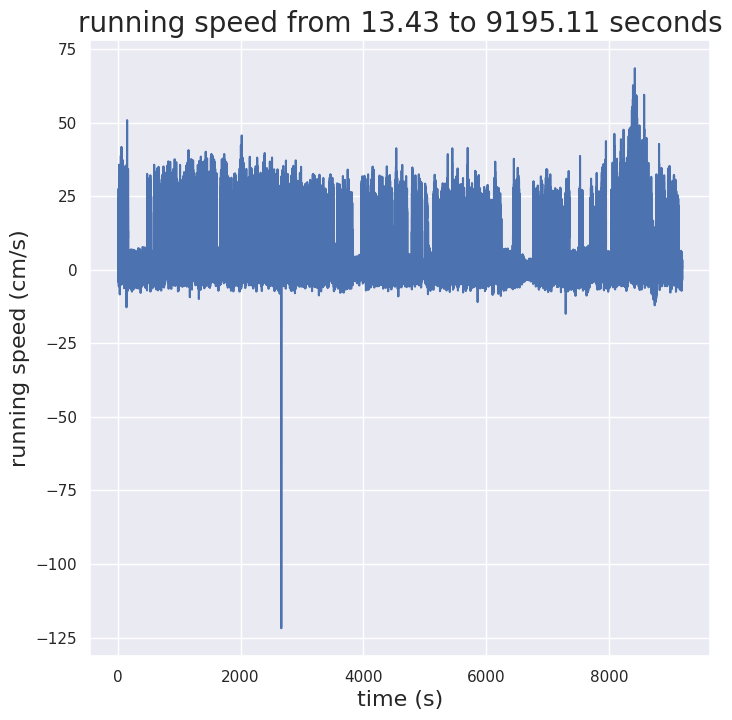

In [26]:
running_speed_midpoints = session.running_speed["start_time"] + (session.running_speed["end_time"] - session.running_speed["start_time"]) / 2
plot_running_speed(
    running_speed_midpoints, 
    session.running_speed["velocity"], 
    start_index=0,
    stop_index=366036
)
plt.show()

(2600.0, 2700.0)

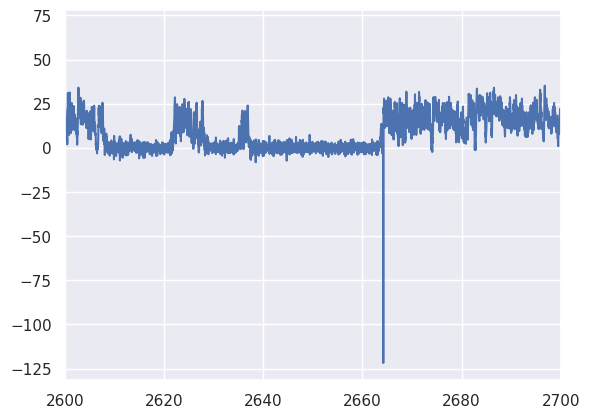

In [97]:
plt.plot(running_speed_midpoints,session.running_speed["velocity"])
plt.xlim([2600,2700])

(2500.0, 2513.0)

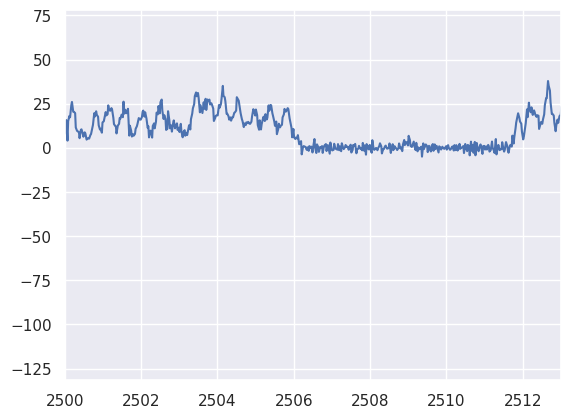

In [32]:
plt.plot(running_speed_midpoints,session.running_speed["velocity"])
plt.xlim([2500,2513])

In [73]:
time_velocity_df = pd.concat([running_speed_midpoints, session.running_speed["velocity"]],axis=1,keys=['running_speed_midpoint','velocity'])
time_velocity_df

,running_speed_midpoint,velocity
0,13.426940,23.570796
1,13.459740,14.813276
2,13.476405,14.352495
3,13.509725,16.674026
4,13.526425,16.747644
...,...,...
366031,9195.012540,0.540036
366032,9195.045945,1.681892
366033,9195.062805,-1.833893
366034,9195.096245,1.990784


In [102]:
# Removing the -125 outlier (shown above)
outlier_index = time_velocity_df[time_velocity_df.velocity<-100].index.item()
time_velocity_df = time_velocity_df.drop(outlier_index)

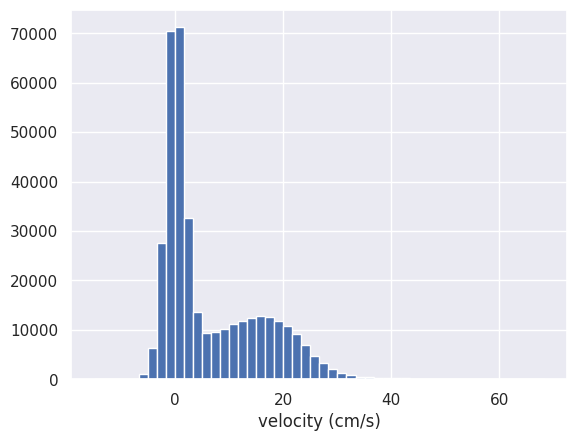

In [107]:
plt.hist(time_velocity_df.velocity,bins=50)
plt.xlabel('velocity (cm/s)')
plt.show()

In [57]:
VELOCITY_THRESHOLD = 8

In [85]:
stim_flashes = session.get_stimulus_table(['flashes'])
stim_flashes

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3647,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1274.523973,1.0,flashes,1274.774189,0.250216,244
3648,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1276.525623,1.0,flashes,1276.775842,0.250219,244
3649,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1278.527343,1.0,flashes,1278.777552,0.250209,245
3650,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1280.529013,1.0,flashes,1280.779222,0.250209,244
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1282.530723,1.0,flashes,1282.780924,0.250201,245
...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1564.766513,1.0,flashes,1565.016712,0.250199,245
3793,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1566.768143,1.0,flashes,1567.018352,0.250209,244
3794,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1568.769833,1.0,flashes,1569.020042,0.250209,244


In [86]:
flash_cat_inds = []
flash_cat_isRunning = []

for stim_id,stim_pres in stim_flashes.iterrows():
    # From running velocity dataframe, select all recorded velocity values during presentation of a single stimulus (between start and end of a flash)
    filtered_df = time_velocity_df[(time_velocity_df.running_speed_midpoint >= stim_pres.start_time) & (time_velocity_df.running_speed_midpoint <= stim_pres.stop_time)]
    # Calculate mean velocity during this presentation
    vel_mean = filtered_df.velocity.mean()
    # Assign boolean classification and store in a Series
    isRunning = False
    if vel_mean >= VELOCITY_THRESHOLD: isRunning = True
    flash_cat_inds.append(stim_id)
    flash_cat_isRunning.append(isRunning)
flash_cat_series = pd.Series(flash_cat_isRunning, index=flash_cat_inds)

In [88]:
stim_flashes['isRunning'] = flash_cat_series
stim_flashes

,color,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id,isRunning
stimulus_presentation_id,,,,,,,,,,,,,
3647,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1274.523973,1.0,flashes,1274.774189,0.250216,244,True
3648,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1276.525623,1.0,flashes,1276.775842,0.250219,244,True
3649,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1278.527343,1.0,flashes,1278.777552,0.250209,245,True
3650,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1280.529013,1.0,flashes,1280.779222,0.250209,244,True
3651,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1282.530723,1.0,flashes,1282.780924,0.250201,245,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3792,1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1564.766513,1.0,flashes,1565.016712,0.250199,245,True
3793,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1566.768143,1.0,flashes,1567.018352,0.250209,244,True
3794,-1.0,0.8,0.0,"[0.0, 0.0]","[300.0, 300.0]","[0.0, 0.0]",1568.769833,1.0,flashes,1569.020042,0.250209,244,True


In [93]:
print(f'{stim_flashes[stim_flashes.isRunning==True].shape[0]} presentations where animal is running')
print(f'{stim_flashes[stim_flashes.isRunning==False].shape[0]} presentations where animal is not running')

112 presentations where animal is running
38 presentations where animal is not running


# 12) Visualising stimulus-averaged LFP trace with respect to stimulus and running conditions

In [154]:
def align_LFPs(stim_presentations, lfp_slice, channel_to_select, window_range=[-0.5,0.5], sampling_frequency=1250):
    presentation_times = stim_presentations.start_time.values
    presentation_ids = stim_presentations.index.values
    
    window_length = window_range[1]-window_range[0] # in seconds
    # trial_window = np.arange(-0.5, 3.5, 1/1250) # np.arange(start, stop, step)
    trial_window = np.linspace(window_range[0], window_range[1], int(window_length*sampling_frequency))
    # Trial window array (including 0.5s before and 0.5s after stimulus) is added to each timepoint linked to flash stimulus presentation
    # Then all of these stim-presentation-related trial windows are concatenated into a single array
    time_selection = np.concatenate([trial_window + t for t in presentation_times])
    
    # Important to note that 1/500 increment here corresponds to downsampling to 500Hz
    
    # This repeatedly assigns basic trial window values (-0.5s:0.5s) to every stimulus presentation id, under the column label of 'time_from_presentation_onset'
    inds = pd.MultiIndex.from_product((presentation_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))
    
    # Selecting LFP data at trial window constrained flash presentation times by the nearest value available
    # Saving this into a newly created 'aligned_lfp' inside of xarray dataset
    dataset = lfp_slice.sel(channel=channel_to_select).sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    # Assigning new variabes ('presentation_id' and 'time_from_presentation_onset' from inds) to the xarray dataset
    # Removing time variable
    # Now, for each presentation_id, there is a corresponding time_from_presentation_onset-long array of LFP data for all the channels
    dataset = dataset.assign(time=inds).unstack('time')
    return dataset['aligned_lfp']

In [158]:
toWhite_running_flashes = stim_flashes[(stim_flashes.stimulus_condition_id==245) & (stim_flashes.isRunning)]
print('toWhite_running_flashes', toWhite_running_flashes.shape[0], 'presentations')

toBlack_running_flashes = stim_flashes[(stim_flashes.stimulus_condition_id==244) & (stim_flashes.isRunning)]
print('toBlack_running_flashes', toBlack_running_flashes.shape[0], 'presentations')

toWhite_nonrunning_flashes = stim_flashes[(stim_flashes.stimulus_condition_id==245) & (stim_flashes.isRunning==False)]
print('toWhite_nonrunning_flashes', toWhite_nonrunning_flashes.shape[0], 'presentations')

toBlack_nonrunning_flashes = stim_flashes[(stim_flashes.stimulus_condition_id==244) & (stim_flashes.isRunning==False)]
print('toBlack_nonrunning_flashes', toBlack_nonrunning_flashes.shape[0], 'presentations')

toWhite_running_flashes 59 presentations
toBlack_running_flashes 53 presentations
toWhite_nonrunning_flashes 16 presentations
toBlack_nonrunning_flashes 22 presentations


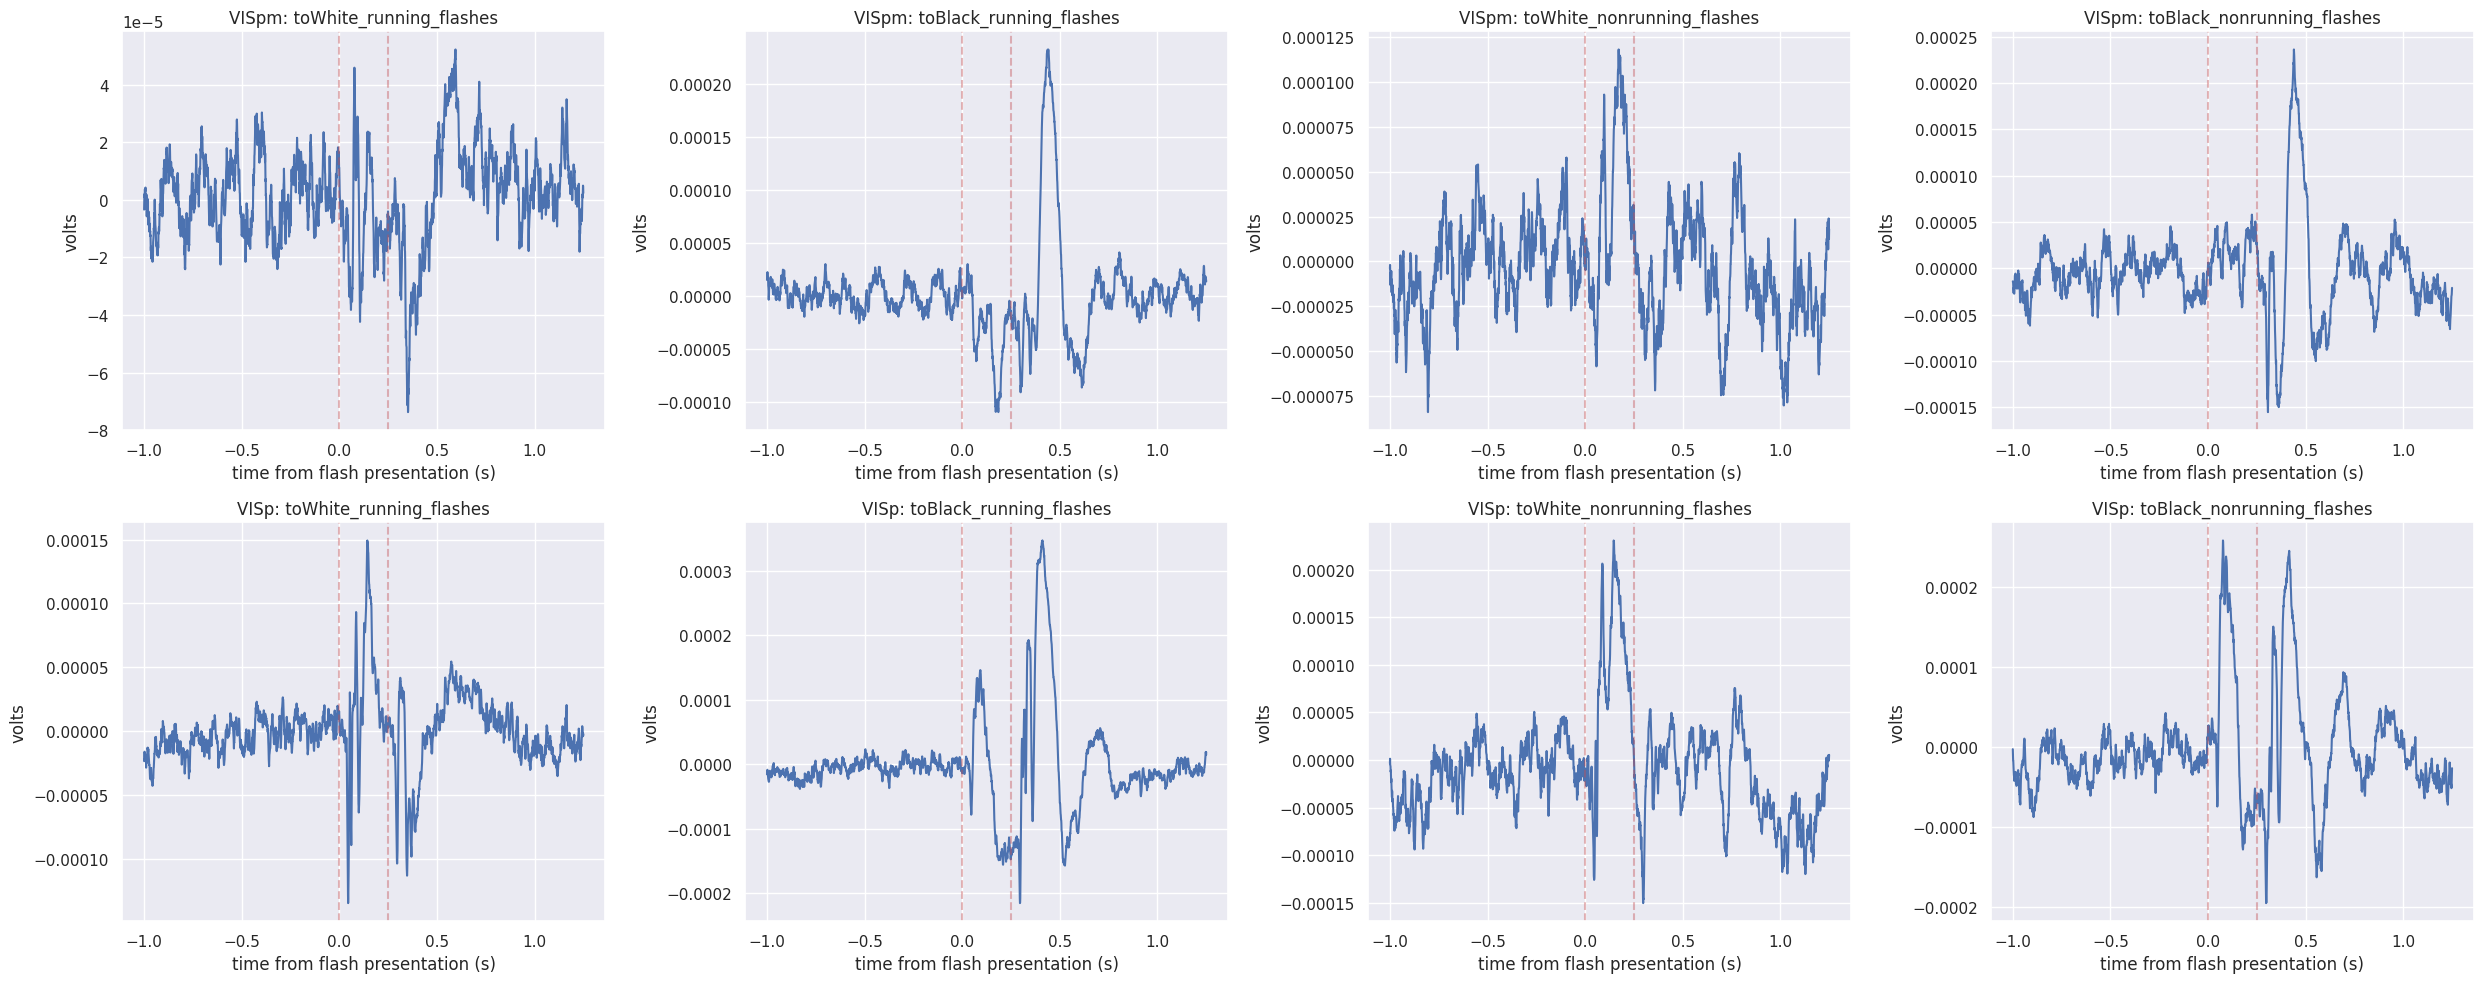

In [175]:
fig, ax = plt.subplots(nrows=2,ncols=4,figsize=(25,10))

window_range = [-1,1.25]
sf = 1250

# VISpm

aligned_lfp = align_LFPs(toWhite_running_flashes, VISpm_lfp_slice, VISpm_max_channel, window_range=window_range, sampling_frequency=sf)
ax[0][0].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[0][0].set_title('VISpm: toWhite_running_flashes')

aligned_lfp = align_LFPs(toBlack_running_flashes, VISpm_lfp_slice, VISpm_max_channel, window_range=window_range, sampling_frequency=sf)
ax[0][1].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[0][1].set_title('VISpm: toBlack_running_flashes')

aligned_lfp = align_LFPs(toWhite_nonrunning_flashes, VISpm_lfp_slice, VISpm_max_channel, window_range=window_range, sampling_frequency=sf)
ax[0][2].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[0][2].set_title('VISpm: toWhite_nonrunning_flashes')

aligned_lfp = align_LFPs(toBlack_nonrunning_flashes, VISpm_lfp_slice, VISpm_max_channel, window_range=window_range, sampling_frequency=sf)
ax[0][3].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[0][3].set_title('VISpm: toBlack_nonrunning_flashes')

# VISp

aligned_lfp = align_LFPs(toWhite_running_flashes, VISp_lfp_slice, VISp_max_channel, window_range=window_range, sampling_frequency=sf)
ax[1][0].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[1][0].set_title('VISp: toWhite_running_flashes')

aligned_lfp = align_LFPs(toBlack_running_flashes, VISp_lfp_slice, VISp_max_channel, window_range=window_range, sampling_frequency=sf)
ax[1][1].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[1][1].set_title('VISp: toBlack_running_flashes')

aligned_lfp = align_LFPs(toWhite_nonrunning_flashes, VISp_lfp_slice, VISp_max_channel, window_range=window_range, sampling_frequency=sf)
ax[1][2].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[1][2].set_title('VISp: toWhite_nonrunning_flashes')

aligned_lfp = align_LFPs(toBlack_nonrunning_flashes, VISp_lfp_slice, VISp_max_channel, window_range=window_range, sampling_frequency=sf)
ax[1][3].plot(aligned_lfp.time_from_presentation_onset, aligned_lfp.mean(dim='presentation_id'))
ax[1][3].set_title('VISp: toBlack_nonrunning_flashes')

for i in range(4):
    ax[0][i].set_xlabel('time from flash presentation (s)')
    ax[0][i].set_ylabel('volts')
    ax[1][i].set_xlabel('time from flash presentation (s)')
    ax[1][i].set_ylabel('volts')
    ax[0][i].axvline(x=0, color='r', linestyle='--', alpha=0.4)
    ax[0][i].axvline(x=0.25, color='r', linestyle='--', alpha=0.4)
    ax[1][i].axvline(x=0, color='r', linestyle='--', alpha=0.4)
    ax[1][i].axvline(x=0.25, color='r', linestyle='--', alpha=0.4)

plt.tight_layout()
# plt.savefig(f'stimulus_averaged_lfps_session_{session_id}.png')
plt.show()